# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
%%capture
!pip install numpy --upgrade;
!pip install --upgrade ipython;
!pip -q install ./python;

The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

### 5. Train the Agent with MADDPG

#### 5.1. Set up

In [6]:
import gym
import random
import torch
#import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from maddpg_agent import Agent, OUNoise

#### 5.2. Initialize the agent

In [7]:
agent = Agent(state_size=state_size, action_size=action_size, num_agents=num_agents, random_seed=3)

Main definitions for MADDPG algorithm:

- **Multy Agent Deep Deterministic Policy Gradient(MADDPG):**

"Extends DDPG into a multi-agent policy gradient algorithm where decentralized agents learn a centralized critic based on the observations and actions of all agents. It leads to learned policies that only use local information (i.e. their own observations) at execution time, does not assume a differentiable model of the environment dynamics or any particular structure on the communication method between agents, and is applicable not only to cooperative interaction but to competitive or mixed interaction involving both physical and communicative behavior. The critic is augmented with extra information about the policies of other agents, while the actor only has access to local information. After training is completed, only the local actors are used at execution phase, acting in a decentralized manner" 

Took from: https://paperswithcode.com/method/maddpg

- **Architecture of Actor Network**


    - Input: 24
    - output: 2
    - Number of layers: 3
        - layer 1:
            - number of neurons: 128
            - activation function: ReLU
        - layer 2:
            - number of neurons: 64
            - activation function: ReLU
        - layer 3:
            - number of neurons: 64
            - activation function: ReLU
    - Batch normalization: yes            


- **Architecture of Critic Network**


    - Batch normalization: yes
    - Input: 24
    - output: 1
    - Number of layers: 2
        - layer 1:
            - number of neurons: 64
            - activation function: ReLU
        - layer 2:
            - number of neurons: 64
            - activation function: ReLU
    - Batch normalization: yes            

- **Hyperparameters:**

```Python
BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 512        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 5e-2              # for soft update of target parameters
LR_ACTOR = 5e-4         # learning rate of the actor 
LR_CRITIC = 5e-4        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay
```

In [8]:
def maddpg(n_episodes, max_t, print_every):
    scores_deque = deque(maxlen=print_every)
    scores = []
    avg_scores = []   
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations
        agent.reset()
        score = np.zeros(num_agents)
        
        for t in range(max_t):
            action1 = agent.act(state[0])
            action2 = agent.act(state[1])
            actions = np.concatenate((action1, action2), axis=0)
            actions = np.clip(actions, -1, 1)
            env_info = env.step(actions)[brain_name]
            next_state = env_info.vector_observations
            reward = env_info.rewards
            done = env_info.local_done
            agent.step(state, actions, reward, next_state, done)
            state = next_state
            score += reward
            if np.any(done):
                break
                
        scores_deque.append(np.max(score))
        scores.append(np.max(score))    
        avg_scores.append(np.mean(scores_deque)) 
        
        print('\rEpisode {}\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores_deque)), end="")
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque) > 0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.4f}'.format(i_episode,np.mean(scores_deque)))
            break

    return scores, avg_scores

#### 5.4. Set variables

In [9]:
n_episodes=2500
max_t=300
print_every=100

#### 5.5. Train

In [10]:
scores, avg_scores = maddpg(n_episodes, max_t, print_every)

Episode 100	Average Score: 0.0143
Episode 200	Average Score: 0.1072
Episode 299	Average Score: 0.5028
Environment solved in 299 episodes!	Average Score: 0.5028


#### 5.6. Show results

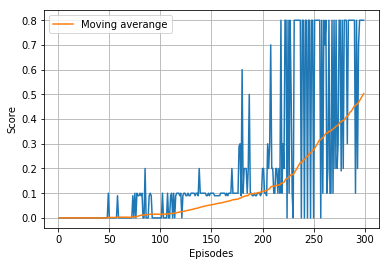

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.plot(np.arange(1, len(avg_scores)+1), avg_scores, label='Moving averange')
plt.ylabel('Score')
plt.xlabel('Episodes')
plt.legend(loc='upper left')
plt.grid()
plt.show()

### 6. Run Trained agent

In [12]:
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth')) 

env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    action1 = agent.act(states[0])
    action2 = agent.act(states[1])
    actions = np.concatenate((action1, action2), axis=0)
    actions = np.clip(actions, -1, 1)                   # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]            # send all actions to tne environment
    next_states = env_info.vector_observations          # get next state (for each agent)
    rewards = env_info.rewards                          # get reward (for each agent)
    dones = env_info.local_done                         # see if episode finished
    scores += env_info.rewards                          # update the score (for each agent)
    states = next_states                                # roll over states to next time step
    if np.any(dones):                                   # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.1450000023469329


In [13]:
env.close()

### 7. Ideas for future work

There are other two possible improvements to the results:

1. Try adding other layer to the critic network.
2. Use a MAPPO algorithm 